# Figure 5

In [1]:
from scipy import stats
import sys, ols
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import xarray as xr, pandas as pd

In [2]:
def global_average(idata):
	"""calculate global average
	e.g., x1=gavg(d1['t2m'])"""
	
	wgt1=np.cos(np.deg2rad(idata.lat))
	ga=(wgt1*idata).sum(dim=['lat'])/wgt1.sum(dim=['lat'])

	return ga

In [3]:
def colorplotLeft(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['bottom','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
    ax.xaxis.set_label_position('top') 
    
    for spx in ['top','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

## load data

In [5]:
mod3=xr.open_dataset('historical/zonal/zonalEnsemble.nc')
forcing=xr.open_dataset('historical/zonal/forcing_zonal.nc')

In [6]:
mod3['time']=pd.to_datetime(mod3.time, format='%Y%m%d.%f')
mod3=mod3.groupby('time.year').mean(dim='time') # annual average

# display mod3 variable
mod3

<xarray.Dataset>
Dimensions:  (lat: 96, lev: 100, lon: 1, sfc: 100, year: 156)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 81.13 79.27 77.41 75.54 ...
  * sfc      (sfc) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * lev      (lev) float64 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 ...
  * year     (year) int64 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 ...
Data variables:
    flux     (year, sfc, lat, lon) float32 -125.333496 -125.69625 -125.65411 ...
    temp2    (year, sfc, lat, lon) float32 256.39337 256.59824 256.68945 ...
    t        (year, lev, lat, lon) float32 237.72585 237.77869 237.9189 ...

In [7]:
# calculate net flux including forcing
# forcing['flux']=forcing.srad0+forcing.trad0
forcing=forcing.assign(flux=forcing.srad0+forcing.trad0)
forcing['time']=np.arange(len(forcing.time))+1850
forcing.rename({'time':'year'},inplace=True)
# forcex=np.array(forcing.flux[:156,]).reshape(156,1,96,1)
flux=(mod3.flux-forcing.flux).squeeze()
flux

<xarray.DataArray 'flux' (year: 156, sfc: 100, lat: 96)>
array([[[-127.65418 , -126.39926 , ..., -100.01607 ,  -93.57836 ],
        [-129.90286 , -128.0136  , ..., -101.08048 ,  -94.99735 ],
        ...,
        [-126.75538 , -125.42142 , ...,  -98.37166 ,  -92.76214 ],
        [-129.64888 , -127.530624, ..., -100.76886 ,  -94.27153 ]],

       [[-126.153595, -126.92601 , ...,  -99.79137 ,  -94.14409 ],
        [-125.53686 , -127.01451 , ...,  -99.27007 ,  -93.37326 ],
        ...,
        [-126.47637 , -126.64117 , ...,  -98.689285,  -93.142334],
        [-129.02544 , -130.23445 , ...,  -98.54623 ,  -93.235245]],

       ...,

       [[-124.708435, -124.87514 , ..., -100.00659 ,  -94.448875],
        [-123.93623 , -122.91533 , ...,  -99.54682 ,  -93.19753 ],
        ...,
        [-125.77086 , -124.41661 , ..., -100.09743 ,  -94.289604],
        [-125.719574, -124.37092 , ...,  -97.61714 ,  -91.66644 ]],

       [[-125.04183 , -123.714455, ...,  -98.46268 ,  -93.67227 ],
        [-126.

global average calculation

In [8]:
fx=global_average(flux)
ts1=global_average(mod3.temp2)
ta1=global_average(mod3.t)

In [10]:
def delta(idata):
    """calculate average difference of last 10 minus first 10 years"""
    dx=idata.isel(year=slice(-10,None)).mean(dim='year')-idata.isel(year=slice(None,10)).mean(dim='year')
    return dx

dflux1=delta(fx)
dts1=delta(ts1)
dta1=delta(ta1)
lambda1=dflux1/dts1;theta1=dflux1/dta1

calculate regional feedbacks

In [11]:
def area_avg(d1c):
    """d1 is xarray
    routine returns average of field in 3 different equal area regions
    SH, equatorial, NH"""
    
    # average into 3 bins of equal area, split around 19.4 N and S
    out1=[global_average(d1c.sel(lat=slice(-19.4,-90)))]
    out1.append(global_average(d1c.sel(lat=slice(19.4,-19.4))))
    out1.append(global_average(d1c.sel(lat=slice(90,19.4))))

    return out1

fx=area_avg(flux)
ts1=area_avg(mod3.temp2)
ta1=area_avg(mod3.t)

In [13]:
# estimate change from first decade to last for each region
dflux=np.array(list(map(delta,fx)))
dts=np.array(list(map(delta,ts1))).squeeze()
dta=np.array(list(map(delta,ta1))).squeeze()
ratioTs=dflux/dts;ratioTa=dflux/dta

## Figure 5

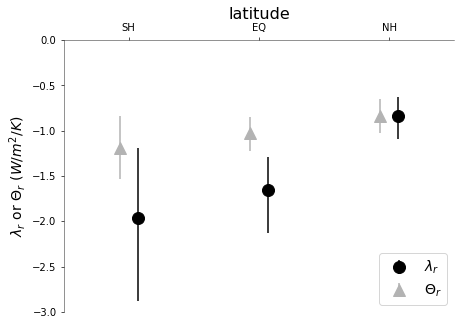

In [14]:
figure(figsize=(7,5))
yerr1=np.average(ratioTs,axis=1)-np.percentile(ratioTs,5,axis=1)
yerr2=np.percentile(ratioTs,95,axis=1)-np.average(ratioTs,axis=1)
errorbar(np.arange(3)+0.07,np.average(ratioTs,axis=1),yerr=[yerr1,yerr2],color='k',fmt='o',\
         markersize=12,label='$\lambda_r$')

yerr1=np.average(ratioTa,axis=1)-np.percentile(ratioTa,5,axis=1)
yerr2=np.percentile(ratioTa,95,axis=1)-np.average(ratioTa,axis=1)
errorbar(np.arange(3)-0.07,np.average(ratioTa,axis=1),yerr=[yerr1,yerr2],color='0.7',fmt='^',\
         markersize=12,label='$\Theta_r$')

xlabel('latitude',fontsize=16);ylabel('$\lambda_r$ or $\Theta_r$ ($W/m^2/K$)',fontsize=14)
xticks([0,1,2],'SH,EQ,NH'.split(','))
xlim(-0.5,2.5)
ylim(-3,0)
legend(loc=4,fontsize=14)
colorplotLeft(gca())

### plot individual high and low lambda models
# ind=np.where(lambda1 < np.percentile(lambda1,5))[0]
# for ii in range(3):
#     plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'k+')
# ind=np.where(lambda1 > np.percentile(lambda1,95))[0]
# for ii in range(3):
#     plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'r+')

# savefig('fig5.eps')
# savefig('fig5')

look at temperature response in each region

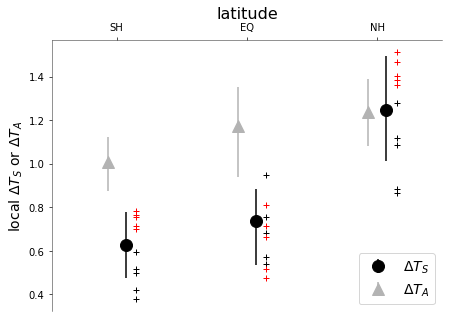

In [15]:
figure(figsize=(7,5))
yerr1=np.average(dts,axis=1)-np.percentile(dts,5,axis=1)
yerr2=np.percentile(dts,95,axis=1)-np.average(dts,axis=1)
errorbar(np.arange(3)+0.07,np.average(dts,axis=1),yerr=[yerr1,yerr2],color='k',fmt='o',\
         markersize=12,label='$\Delta T_S$')

yerr1=np.average(dta,axis=1)-np.percentile(dta,5,axis=1)
yerr2=np.percentile(dta,95,axis=1)-np.average(dta,axis=1)
errorbar(np.arange(3)-0.07,np.average(dta,axis=1),yerr=[yerr1,yerr2],color='0.7',fmt='^',\
         markersize=12,label='$\Delta T_A$')

xlabel('latitude',fontsize=16);ylabel('local $\Delta T_S$ or $\Delta T_A$',fontsize=14)
xticks([0,1,2],'SH,EQ,NH'.split(','))
xlim(-0.5,2.5)

ind=np.where(lambda1 < np.percentile(lambda1,5))[0]
for ii in range(3):
    plot(np.zeros(len(ind))+ii+0.15,dts[ii,ind],'k+')
ind=np.where(lambda1 > np.percentile(lambda1,95))[0]
for ii in range(3):
    plot(np.zeros(len(ind))+ii+0.15,dts[ii,ind],'r+')

legend(loc=4,fontsize=14)
colorplotLeft(gca())